In [211]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8) 

from sklearn import set_config, preprocessing # предобработка
set_config(transform_output='pandas')
from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam



%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [212]:
data = pd.read_csv('../airline_passengers.csv', index_col='Month', parse_dates=True)

In [213]:
df = data.copy()

In [214]:
df['Log_Pass'] = np.log(df['Passengers'])
df['Diff_Log_Pass'] = df['Log_Pass'].diff()

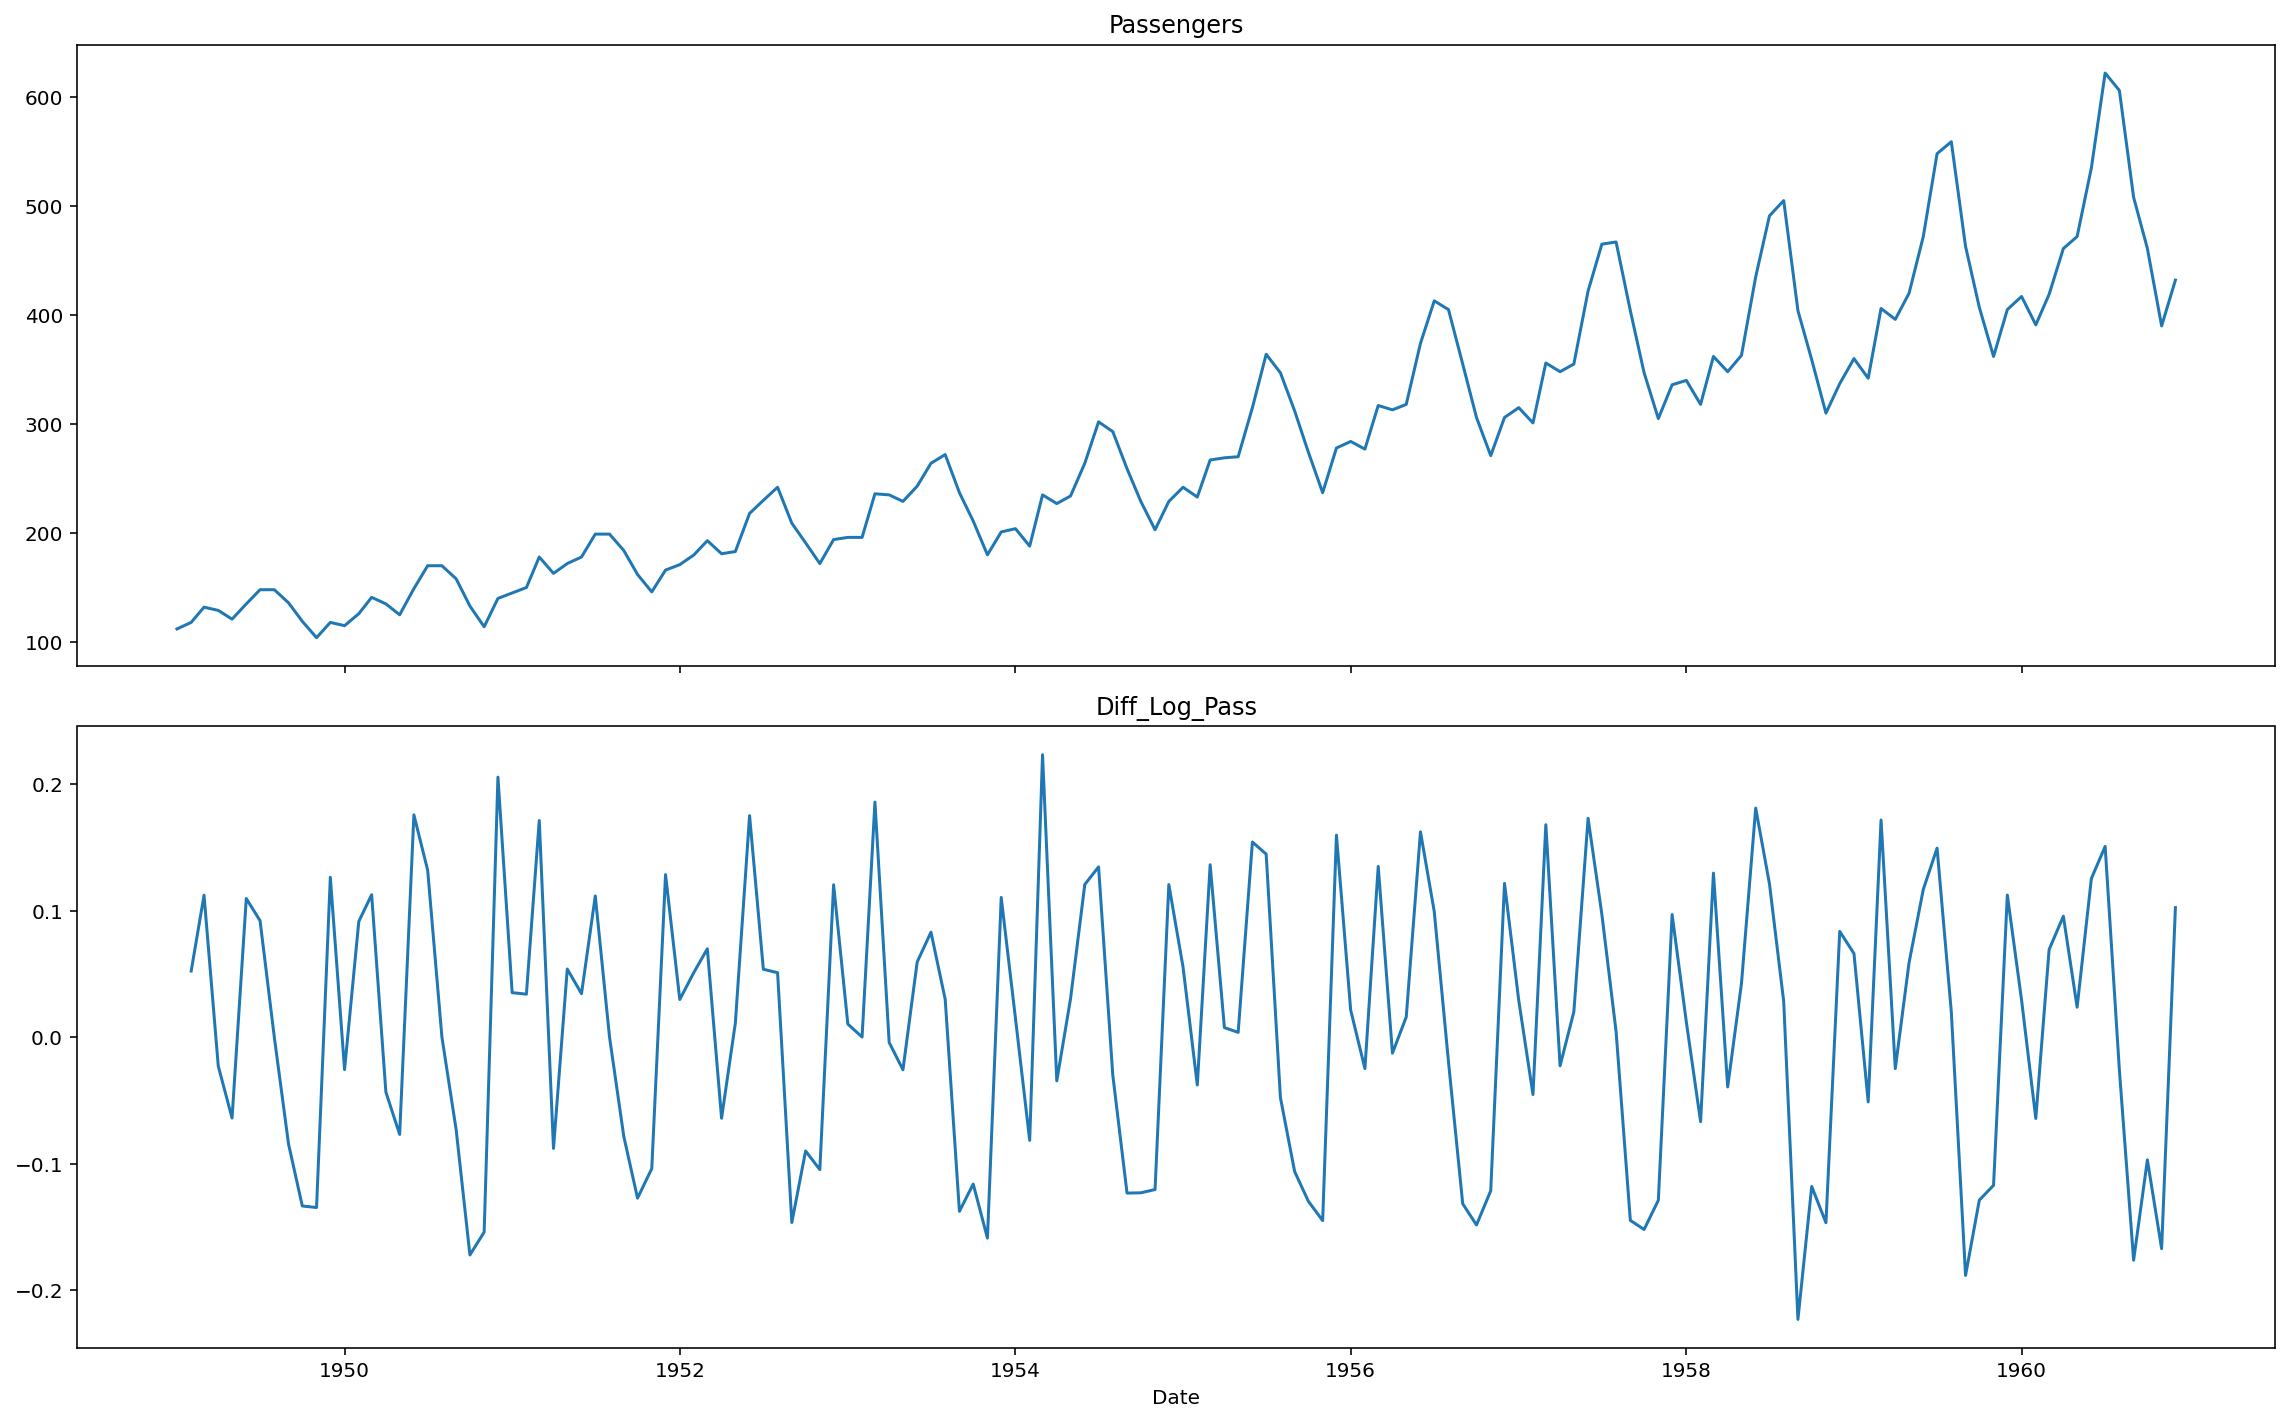

In [215]:
# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert index and columns to NumPy arrays
ind = df.index.to_numpy()
_0 = df['Passengers'].to_numpy()
_1 = df['Diff_Log_Pass'].to_numpy()

ax[0].plot(ind, _0)
ax[0].set_title('Passengers')

ax[1].plot(ind, _1)
ax[1].set_title('Diff_Log_Pass')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [216]:
def adf(x, threshold=0.05):
    results = adfuller(x)
    
    print('Test-Statistic:', results[0])
    print('P-Value:', results[1])
    
    if results[1] < threshold:
        print('Stationary!')
    else:
        print('Non-Stationary')

In [217]:
# первое значение из ряда убираю т.к. после применения diff там теперь nan 
adf(df['Diff_Log_Pass'].values[1:])

Test-Statistic: -2.7171305983881333
P-Value: 0.07112054815085872
Non-Stationary


Не совсем вышло, попытались сделать ряд стационарным. При пороге в 10% он был бы таким.

### Split data

In [218]:
N_test = 12 # Сколько элементов в конце оставить на тестовую выборку
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

### Create supervised dataset
Трансформируя исходый временной ряд получаю датасеты X, y. Т.е. фактически зам генерирую/размечаю данные.

In [219]:
# первое значение из ряда убираю т.к. после применения diff там теперь nan 
series = df['Diff_Log_Pass'].values[1:]

In [220]:
T = 10 # длина истории, котрая используется для прогноза следующего элемента
N = len(series) - T # Num of samples in dataset

X = []
y = []

for t in range(N):
    X.append(series[t:t+T]) # first T elements
    y.append(series[t+T]) # next element for prediction

In [221]:
X = np.array(X).reshape(-1, T)
y = np.array(y)

In [222]:
print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (133, 10) y.shape: (133,)


Split dataset

In [223]:
X_train, X_test = X[:-N_test], X[-N_test:]
y_train, y_test = y[:-N_test], y[-N_test:]

### 1-step forecast
Пу сути это прогноз только одного будущего значения. Только на один шаг. Следующее значение можно предсказать только когда появится предыдущее.

Они ведь и сохранены у нас в матрице признаков X.

In [224]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

После обучения модели можно сразу получить метрики

In [225]:
lr.score(X_train, y_train)

0.6837135048453121

In [226]:
lr.score(X_test, y_test)

0.6492870172668169

Или вот так классическим путем, через получение векторов предсказаний

In [227]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [228]:
r2_score(y_train, y_train_pred)

0.6837135048453121

In [229]:
r2_score(y_test, y_test_pred)

0.6492870172668169

In [230]:
mean_absolute_percentage_error(y_test, y_test_pred)

0.8461518951557777

Метрики упали по сравнению со временным рядом, который использовался в прошлом ноутбуке.
Т.к. ряд стационарный и из него исключена трендовая составляющая, то теперь невозможно прогнозировать следующее значение по преддущему.

In [231]:
# Bollean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

# устанавливаю индесы вручную для первых T элементов в временном ряду, 
# т.к. тут накапливаятся история нужной длины для последующего предсказания.
# тут добавил еще еденицу к T т.к. первый элемент NaN в ряду.
train_idx[:T+1] = False

In [232]:
# Предыдущее значение для возвращения от разницы к нормальным величинам
df['Shift_Log_Pass'] = df['Log_Pass'].shift(1)
prev = df['Shift_Log_Pass']

In [233]:
# Last-known train value
last_train = train.iloc[-1]['Log_Pass']

In [234]:
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [235]:
# One-step forecast
# тут я по маске беру предыдущие значения Log_Pass на тренировочной и тестовой выборке и добавляю поэлементно массив прогнозов
# т.е. я конвертирую прогнозы в удобоваримые выличины для визуализации
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + y_train_pred
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + y_test_pred

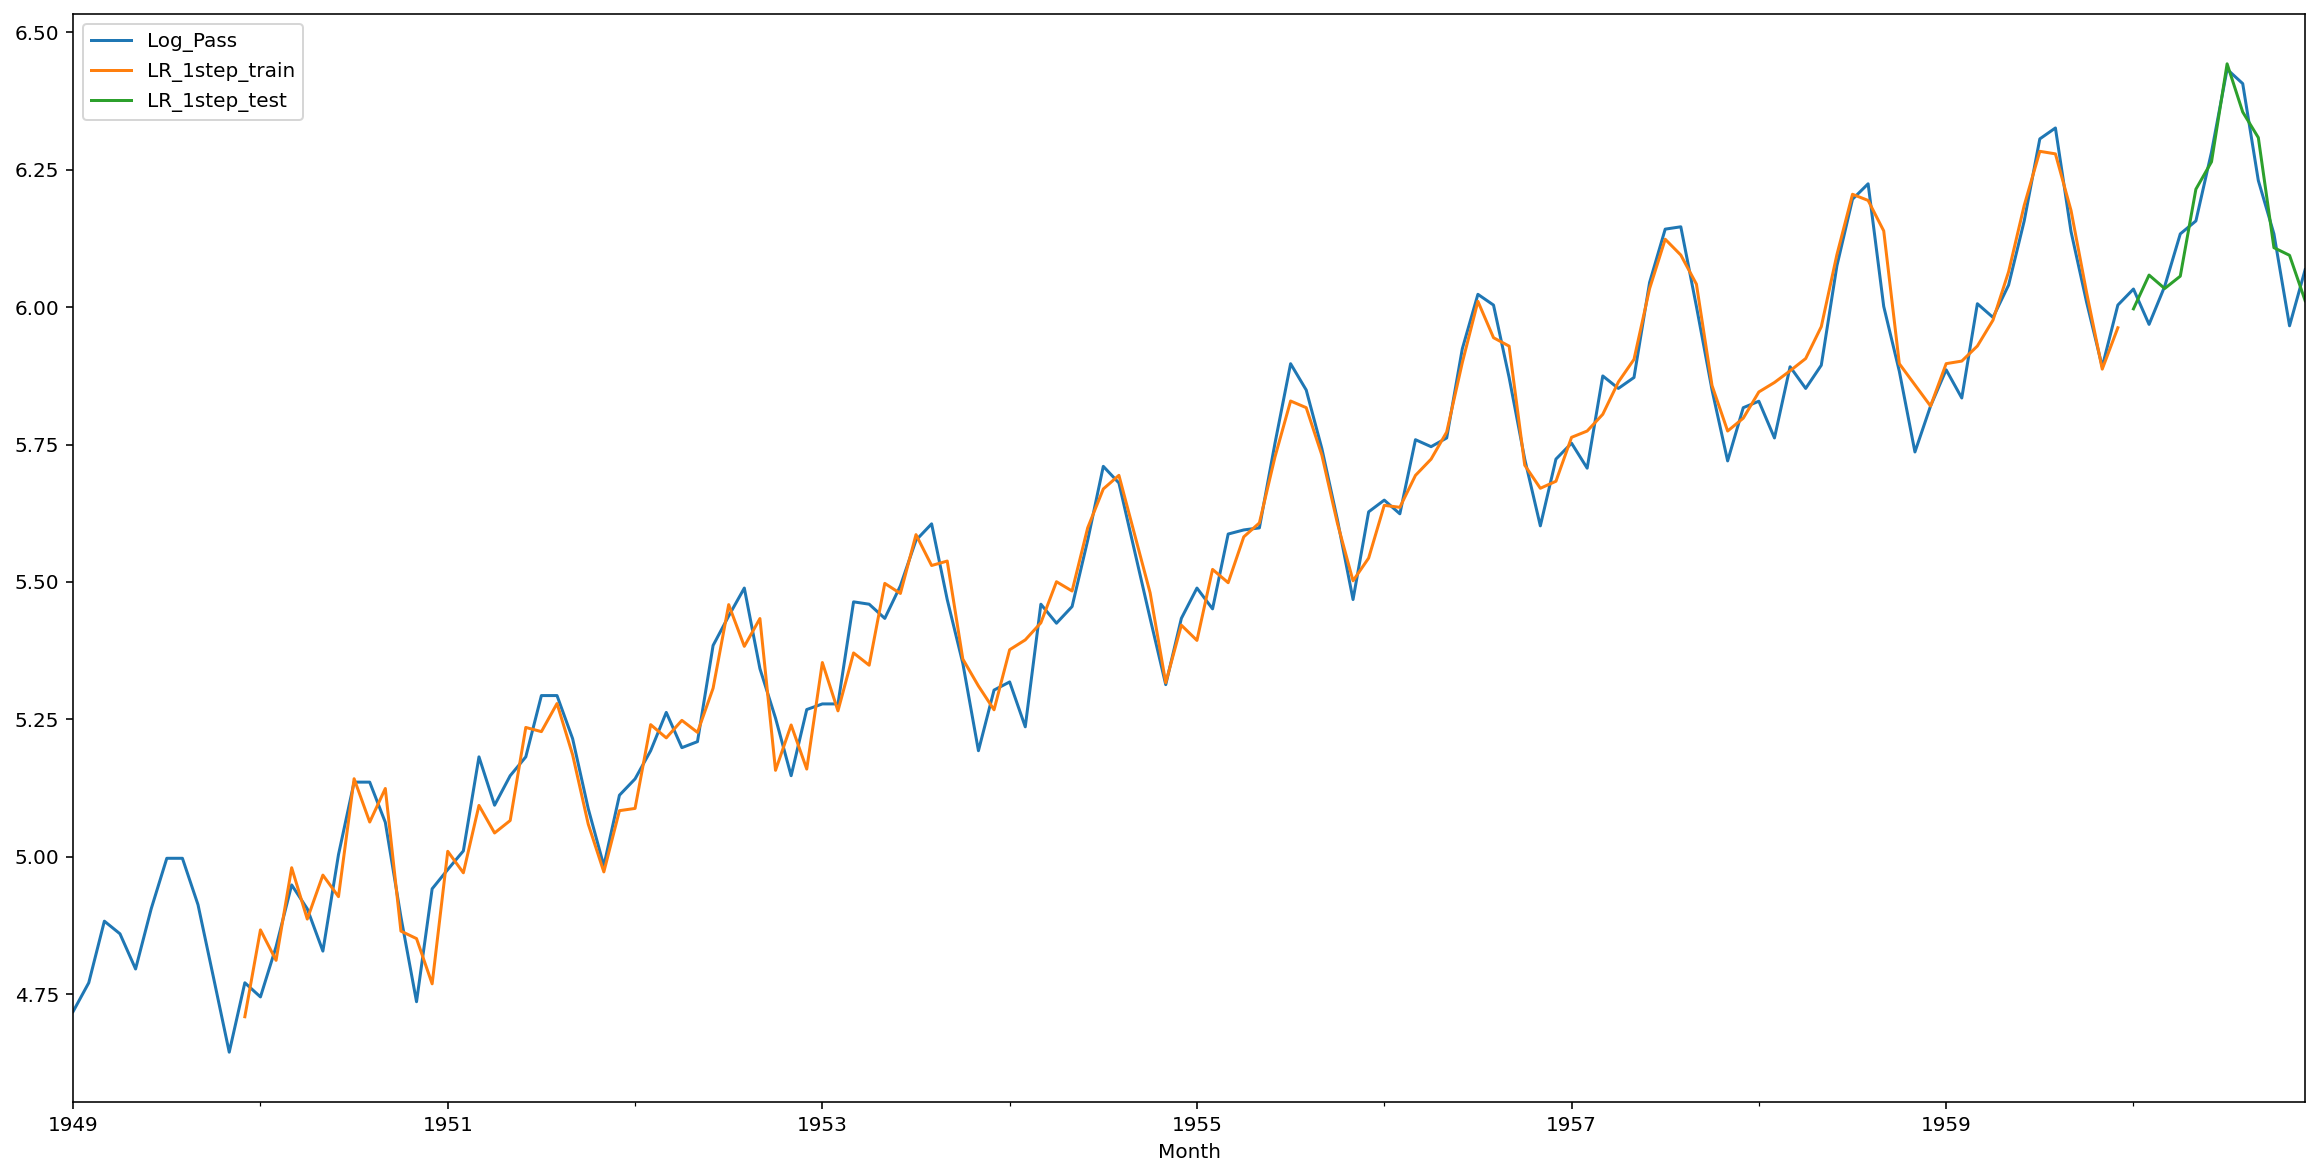

In [236]:
df[['Log_Pass', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(20, 10));

Видно, что модель в таком виде точно попадает в пики и выглядит сильно лучше чем такая же одношаговая модель, но на нестационарном ряду Log_Pass. И при этом метрики упали, но ведь метрики оценивали совсем другие цифры.

### Сравниваю трансформированные данные

In [237]:
df.iloc[-N_test:]

,Passengers,Log_Pass,Diff_Log_Pass,Shift_Log_Pass,LR_1step_train,LR_1step_test
Month,,,,,,
1960-01-01,417,6.033086,0.029199,6.003887,NaN,5.997012
1960-02-01,391,5.968708,-0.064379,6.033086,NaN,6.058472
1960-03-01,419,6.037871,0.069163,5.968708,NaN,6.033987
1960-04-01,461,6.133398,0.095527,6.037871,NaN,6.056449
1960-05-01,472,6.156979,0.023581,6.133398,NaN,6.214746
1960-06-01,535,6.282267,0.125288,6.156979,NaN,6.264528
1960-07-01,622,6.432940,0.150673,6.282267,NaN,6.442876
1960-08-01,606,6.406880,-0.026060,6.432940,NaN,6.355195
1960-09-01,508,6.230481,-0.176399,6.406880,NaN,6.308574


In [238]:
y_test_transform = df.iloc[-N_test:]['Log_Pass'].values
y_test_transform_pred = df.iloc[-N_test:]['LR_1step_test'].values

In [239]:
r2_score(y_test_transform, y_test_transform_pred)

0.8218032348650787

А было 0.69

In [240]:
mean_absolute_percentage_error(y_test_transform, y_test_transform_pred)

0.008623613141312235

А было 0.012613783531097338

Вот как выглядят метрики после трансформации прогноза для сравнения их с предыдущим ноутбуком.

Показатели сильно улучшились.

### Multi-step forecast

In [241]:
multistep_predictions = []

# first test input
last_x = X_test[0]

while len(multistep_predictions) < N_test:
    p = lr.predict(last_x.reshape(1, -1))[0]
    
    # save prediction
    multistep_predictions.append(p)
    
    # make new input, add last predict value as input
    last_x = np.roll(last_x, -1) # сдвигаю радя влево в массиве
    last_x[-1] = p # на место последнего значения ставлю полученный прогноз

In [242]:
# save multi-step forecast to dataframe
# К последнему значению Log_Pass из тренировочной выборки добавляю кумулятивную сумму дельт на окне прогнозирования
# И т.о. получаю на каждом интервале спрогнозированное значение Log_Pass
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

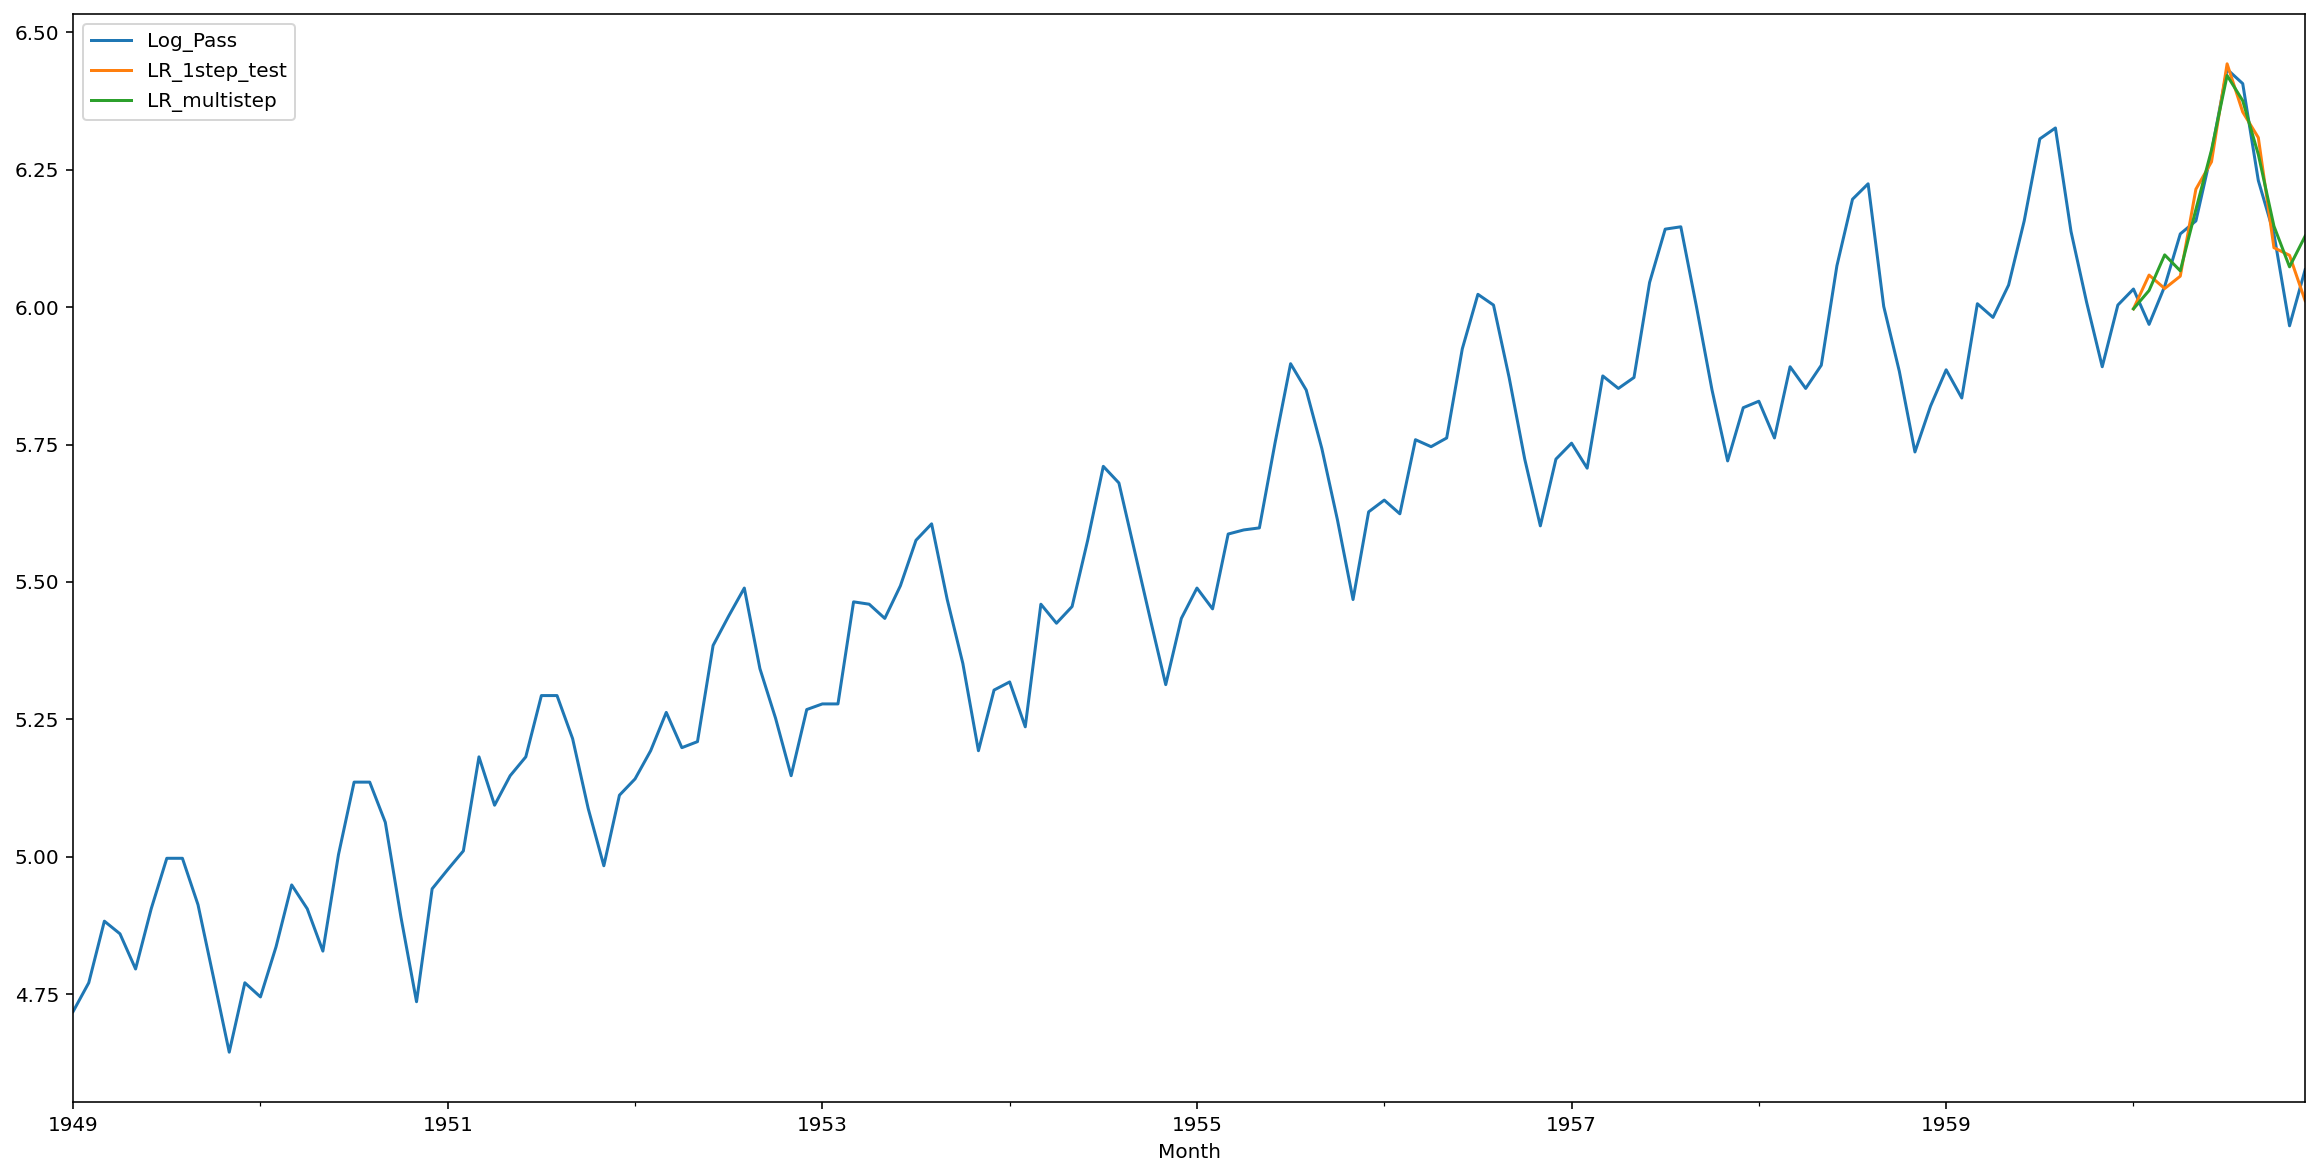

In [243]:
df[['Log_Pass', 'LR_1step_test', 'LR_multistep']].plot(figsize=(20, 10));

In [244]:
y_test_transform = df.iloc[-N_test:]['Log_Pass'].values
y_test_transform_pred = df.iloc[-N_test:]['LR_multistep'].values

In [245]:
r2_score(y_test_transform, y_test_transform_pred)

0.8809949096887302

In [246]:
mean_absolute_percentage_error(y_test_transform, y_test_transform_pred)

0.007109281288502549

По сравнению с пердыдущей моделью LR_1step_test в этом же ноутбуке метрики опять же улучшились

### Create multi-output model
Строми модель, которая на этапе прогноза будет возвращать не одно значений, а массив.

In [247]:
Tx = T # длина истории входящих признаков
Ty = N_test # количество целевых признаков, которые модель выдаст в виде предсказания. Т.е. на сколько шагов вперед производить прогнозирование.

X = []
y = []

for t in range(len(series) - Tx - Ty + 1):
    X.append(series[t:t+Tx]) # признаки как и прежде сохраняю в виде массива длиной Tx
    y.append(series[t+Tx:t+Tx+Ty]) # а целевая метка теперь не одна, а Ty следующих шагов

N = len(X) # итоговая длина датасета после создания

In [248]:
X = np.array(X).reshape(-1, Tx)
y = np.array(y).reshape(-1, Ty)

In [249]:
print('X.shape:', X.shape, 'y.shape:', y.shape)

X.shape: (122, 10) y.shape: (122, 12)


In [250]:
# По сути оставляю в тестовой части только по одной записе, т.к. прогноз будет содержать в реальности 10 шагов вперед
X_train_m, X_test_m = X[:-1], X[-1:]
y_train_m, y_test_m = y[:-1], y[-1:]

In [251]:
# вот на 10 шагов вперед реультаты
y_test_m

array([[ 0.02919915, -0.06437866,  0.06916336,  0.09552712,  0.02358094,
         0.12528776,  0.15067335, -0.02606011, -0.17639854, -0.0970834 ,
        -0.1672513 ,  0.10227885]])

In [252]:
lr = LinearRegression()
lr.fit(X_train_m, y_train_m)

LinearRegression()

In [253]:
lr.score(X_train_m, y_train_m)

0.8141637147930583

In [254]:
y_train_m_pred = lr.predict(X_train_m)
y_test_m_pred = lr.predict(X_test_m)

Т.к. каждый прогноз (как впрочем и целевая метрика) теперь состоит из массива то нужно их оттуда вытаскивать

flatten() или просто через [0]

На тренировочной части метрика не особо релевантна, т.к. в много раз повторяются одни и те же значения

In [255]:
r2_score(y_train_m.flatten(), y_train_m_pred.flatten())

0.8141152619679572

In [256]:
r2_score(y_test_m.flatten(), y_test_m_pred.flatten())

0.7867137438847721

In [257]:
multioutput_mape = mean_absolute_percentage_error(y_test_m.flatten(), y_test_m_pred.flatten())

In [258]:
df.loc[test_idx, 'LR_multioutput'] = last_train + np.cumsum(y_test_m_pred.flatten())

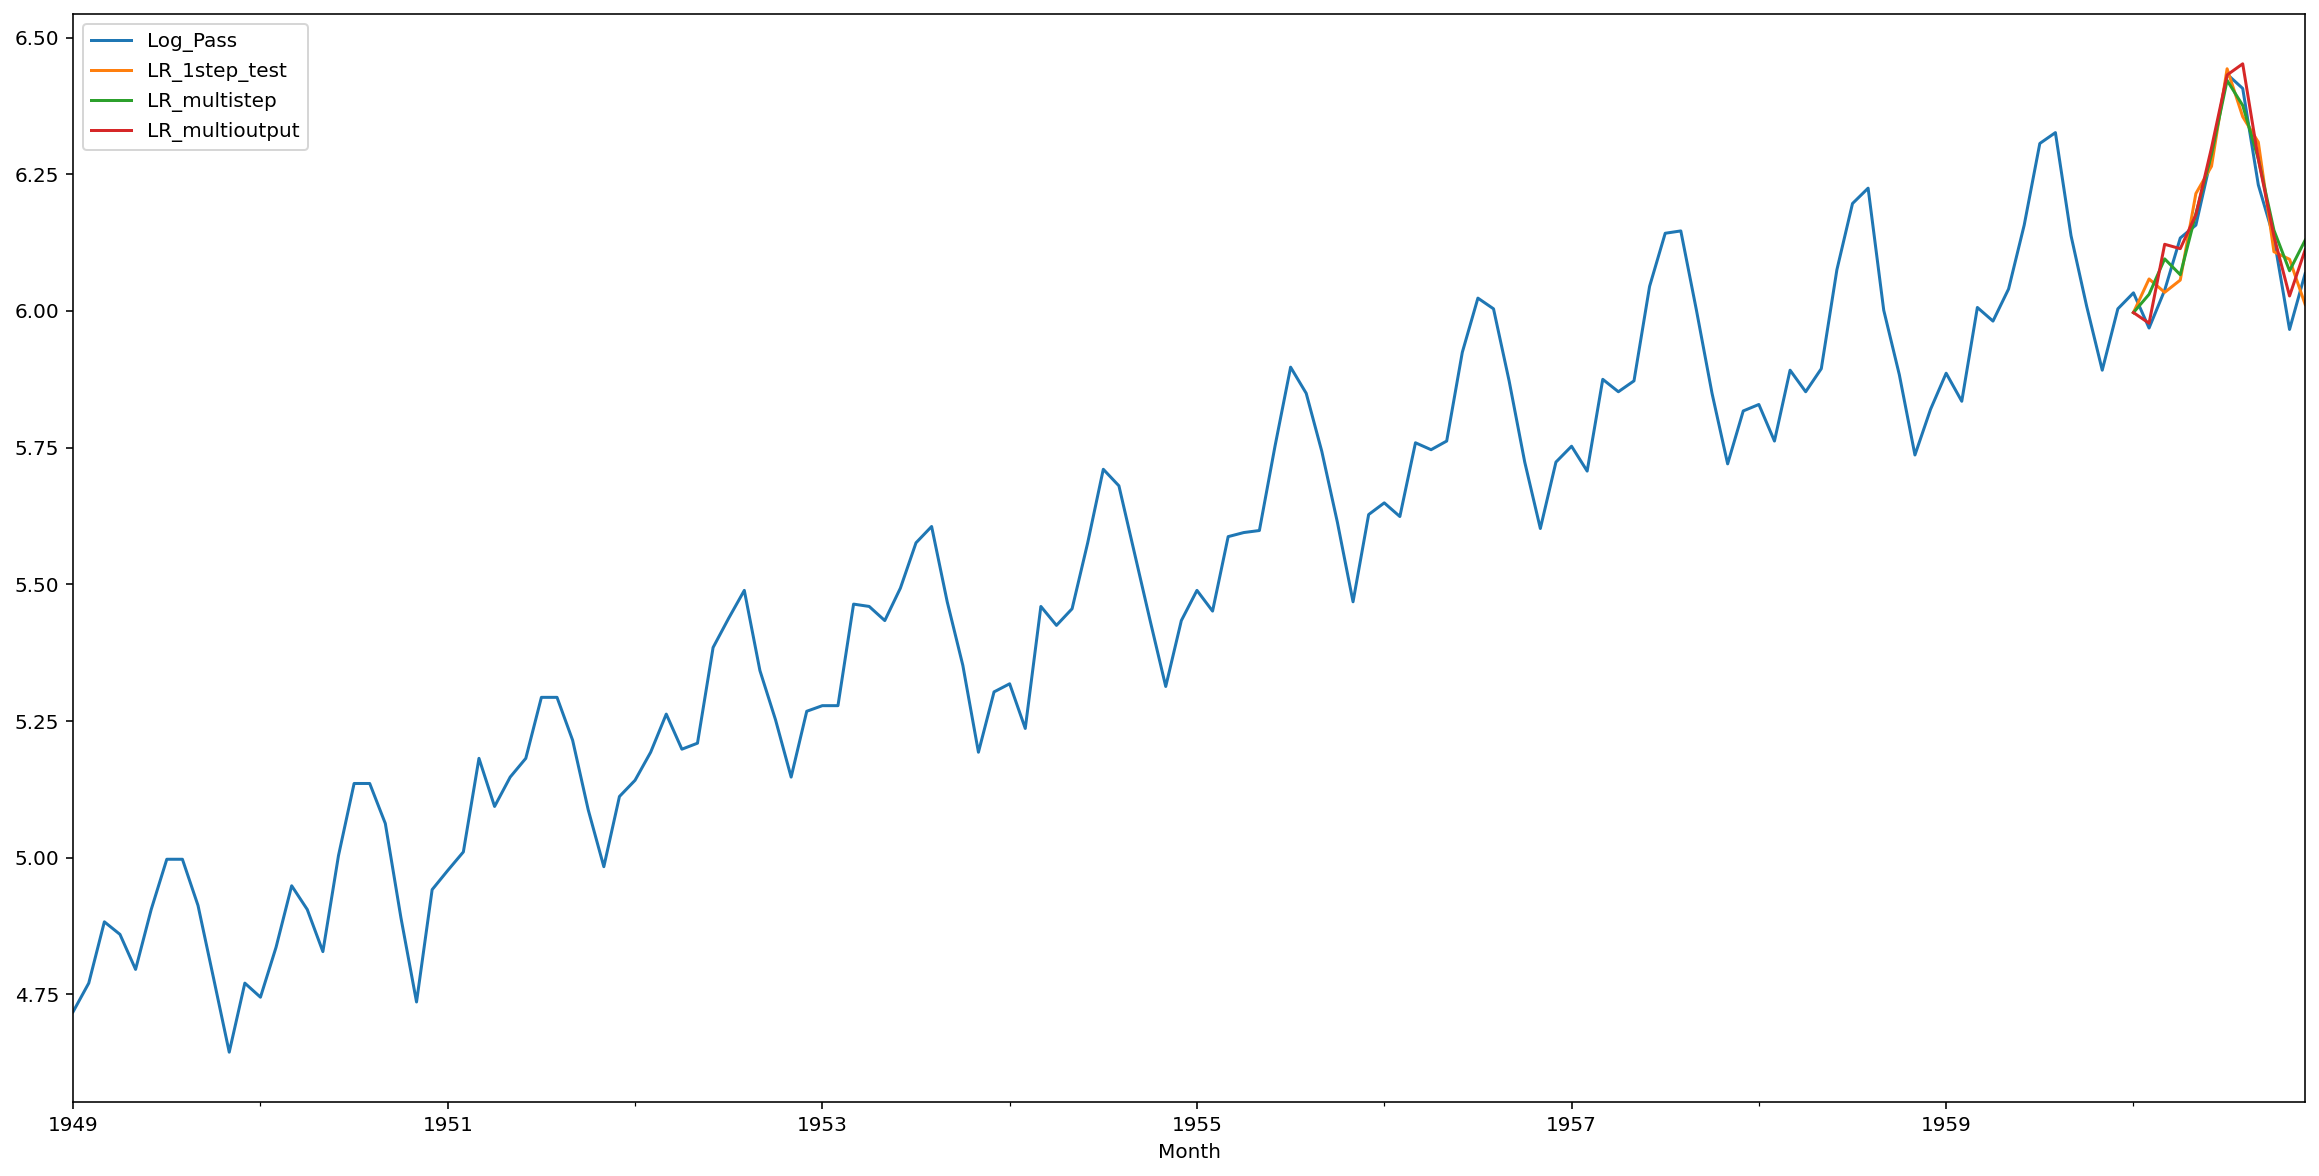

In [259]:
df[['Log_Pass', 'LR_1step_test', 'LR_multistep', 'LR_multioutput']].plot(figsize=(20, 10));

In [260]:
y_test_transform = df.iloc[-N_test:]['Log_Pass'].values
y_test_transform_pred = df.iloc[-N_test:]['LR_multioutput'].values

In [261]:
r2_score(y_test_transform, y_test_transform_pred)

0.9284060010663868

In [262]:
mean_absolute_percentage_error(y_test_transform, y_test_transform_pred)

0.005245261617574856

In [263]:
# MAPE
test_log_pass = df.loc[test_idx, 'Log_Pass']
y_test_pred1 = df.loc[test_idx, 'LR_multistep']
y_test_pred2 = df.loc[test_idx, 'LR_multioutput']

print('LR_multistep MAPE:', mean_absolute_percentage_error(test_log_pass, y_test_pred1))
print('LR_multioutput MAPE:', mean_absolute_percentage_error(test_log_pass, y_test_pred2))

LR_multistep MAPE: 0.007109281288502549
LR_multioutput MAPE: 0.005245261617574856


Вот итоговое сравение метрик МАРЕ приведенное к размерности Log_Pass как в предыдущем ноутбуке.

Там лучшее значение было Multioutput MAPE: 0.007178924475039767

## Test Other Models

In [264]:
def one_stet_and_multi_step_forecast(model, name):
    model.fit(X_train, y_train)
    print('One-step forecast:', name)
    
    # store one-step forecast
    df.loc[train_idx, f'{name}_1step_train'] = prev[train_idx] + model.predict(X_train)
    df.loc[test_idx, f'{name}_1step_test'] = prev[test_idx] + model.predict(X_test)
    
    
    multistep_predictions = []

    # first test input
    last_x = X_test[0]

    while len(multistep_predictions) < N_test:
        p = model.predict(last_x.reshape(1, -1))[0]
        
        # save prediction
        multistep_predictions.append(p)
        
        # make new input, add last predict value as input
        last_x = np.roll(last_x, -1) # сдвигаю радя влево в массиве
        last_x[-1] = p # на место последнего значения ставлю полученный прогноз
    
    # store multi-step forecast
    df.loc[test_idx, f'{name}_multistep_test'] = last_train + np.cumsum(multistep_predictions)
    
    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(y_test, df.loc[test_idx, f'{name}_multistep_test'])
    print(f'MAPE for {name} on test:{mape}')
    
    # plot 1-step and multi-step forecast
    cols = ['Log_Pass',
            f'{name}_1step_train',
            f'{name}_1step_test',
            f'{name}_multistep_test',
            ]
    
    df[cols].plot(figsize=(20, 10));

One-step forecast: LR
MAPE for LR on test:103.60621304463479


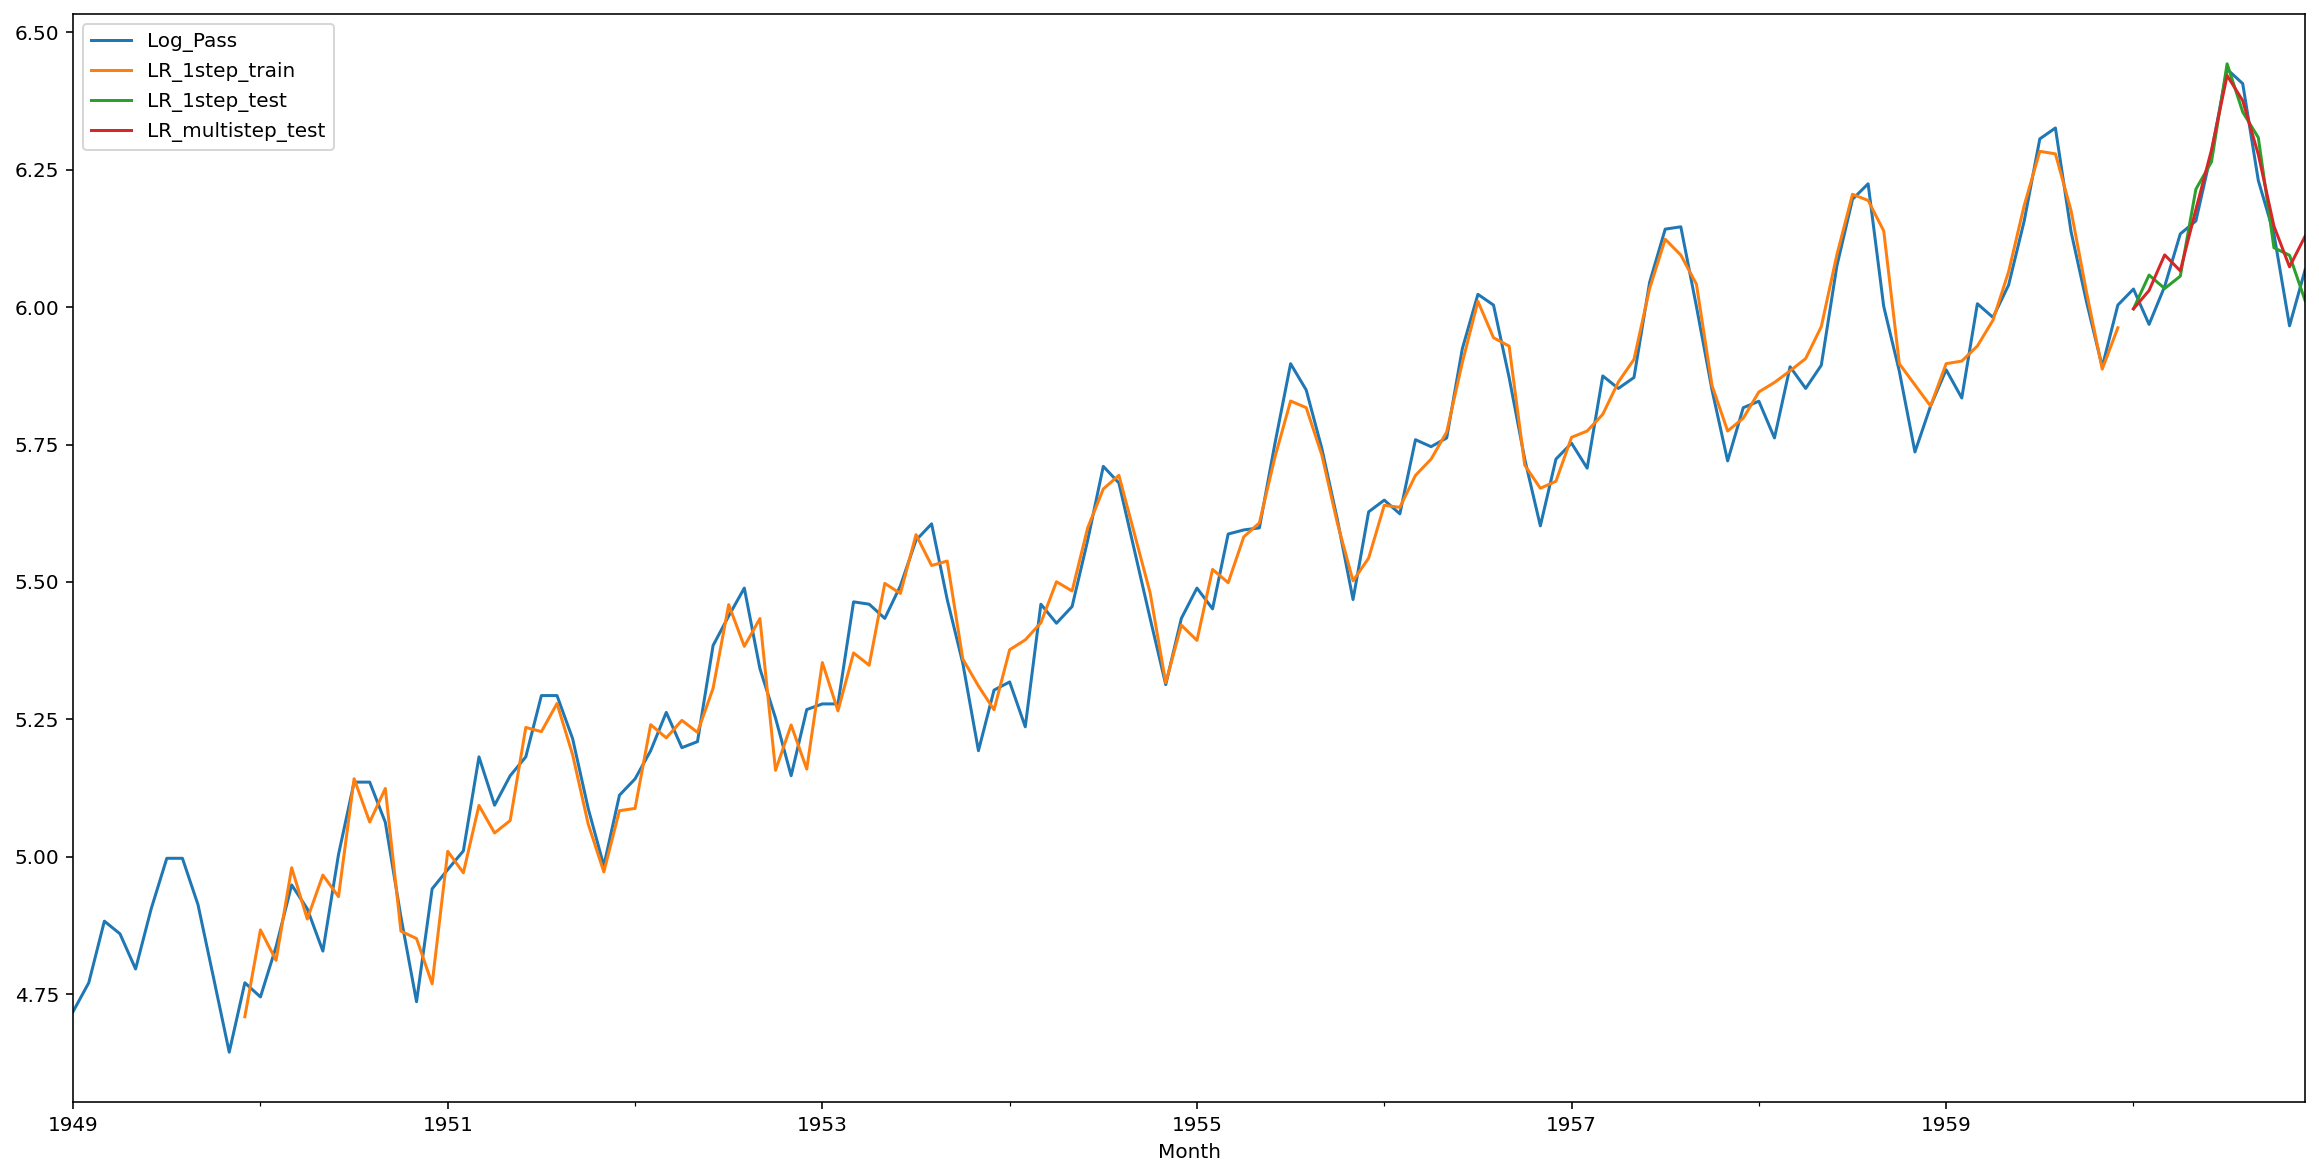

In [265]:
one_stet_and_multi_step_forecast(LinearRegression(), 'LR')

One-step forecast: SRV
MAPE for SRV on test:103.65121236047548


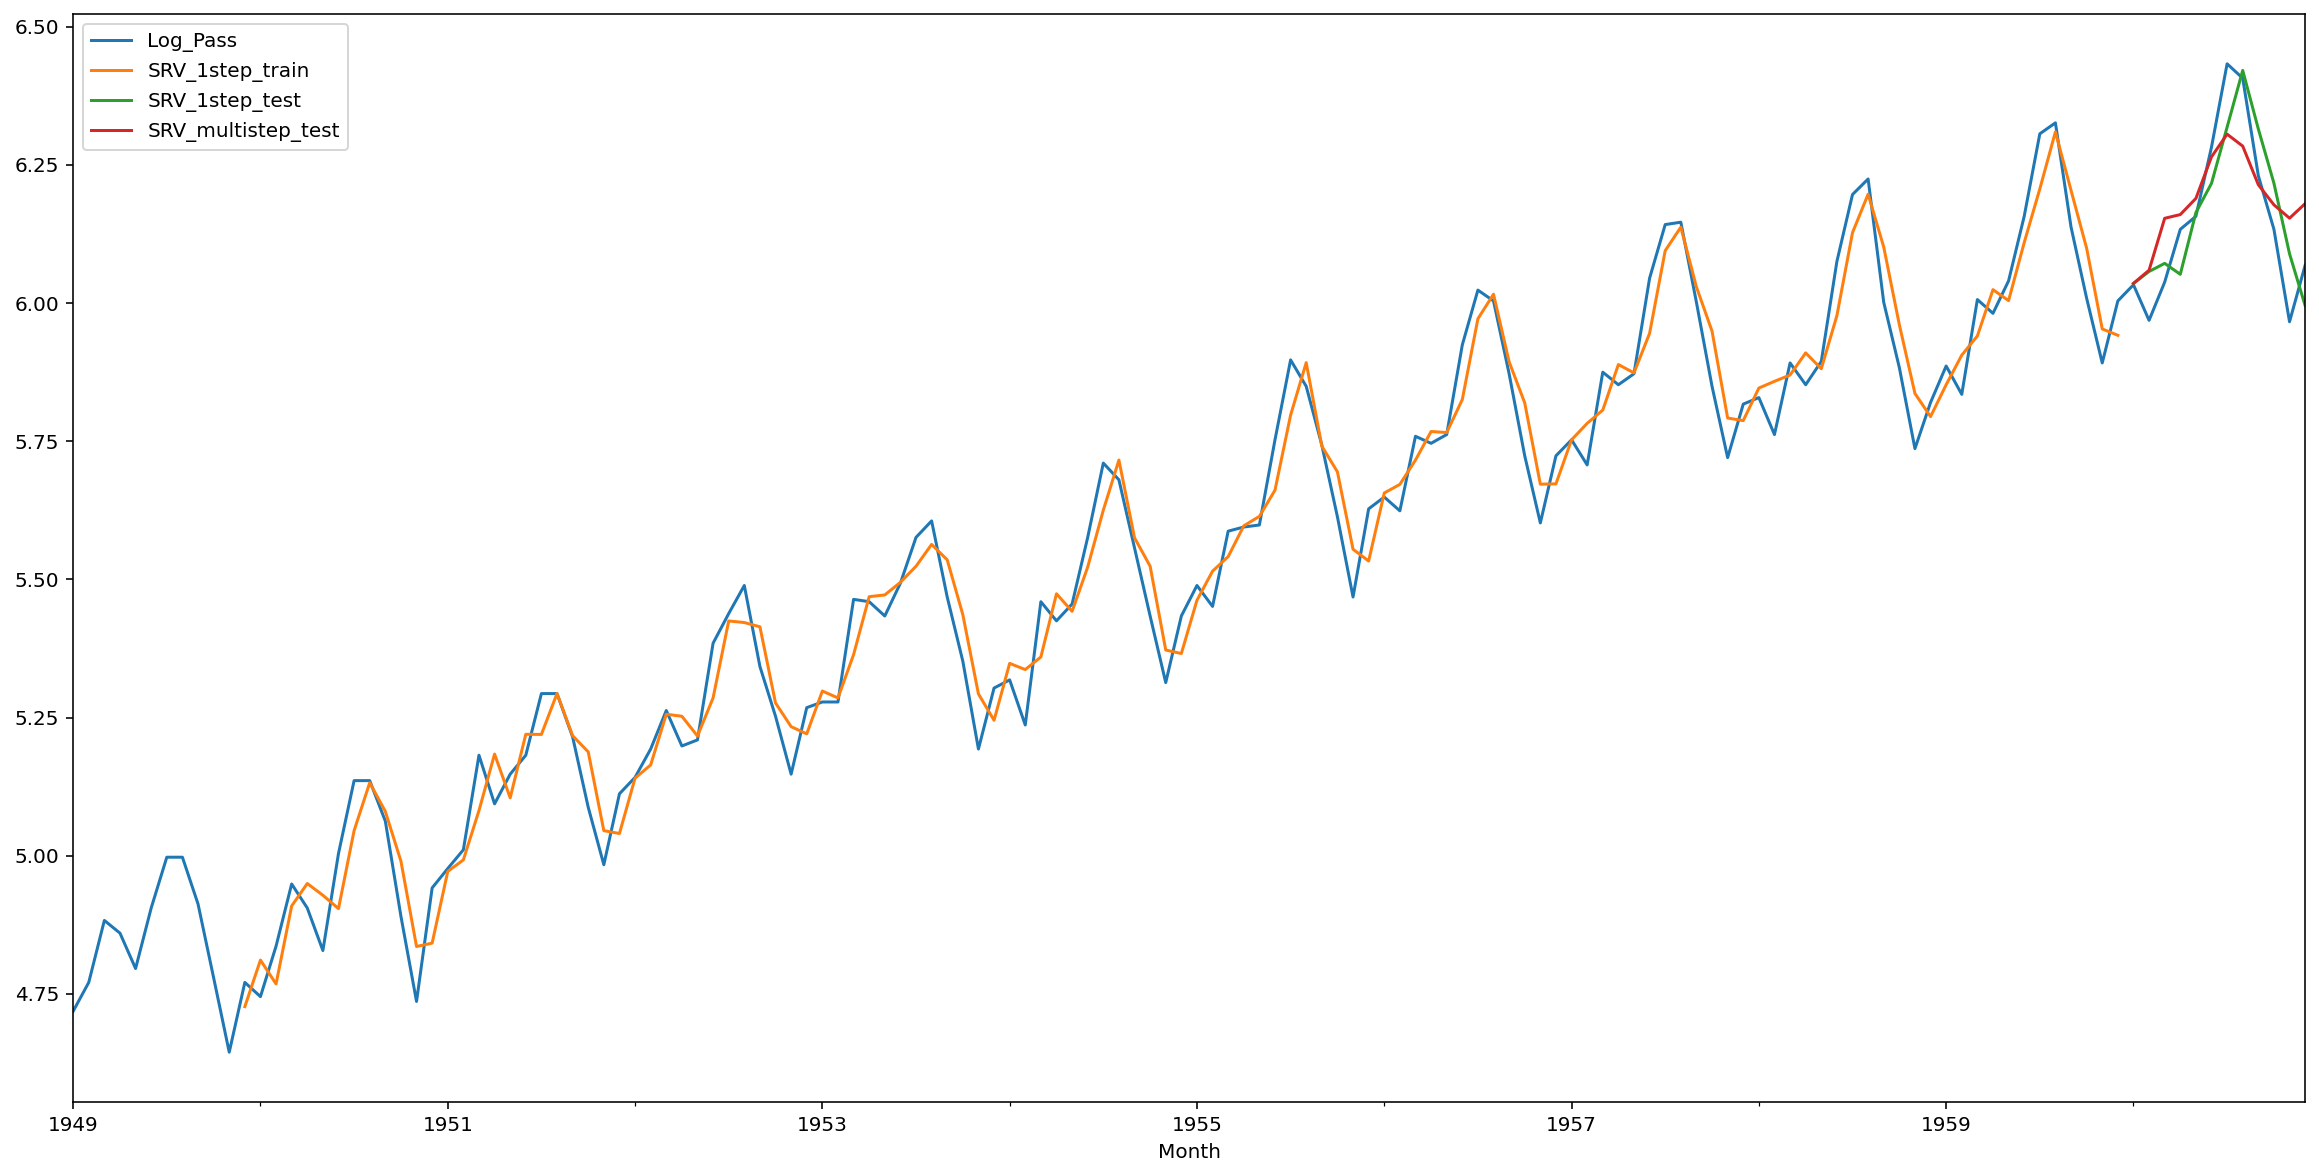

In [266]:
one_stet_and_multi_step_forecast(SVR(), 'SRV')

One-step forecast: RF
MAPE for RF on test:103.4014866191008


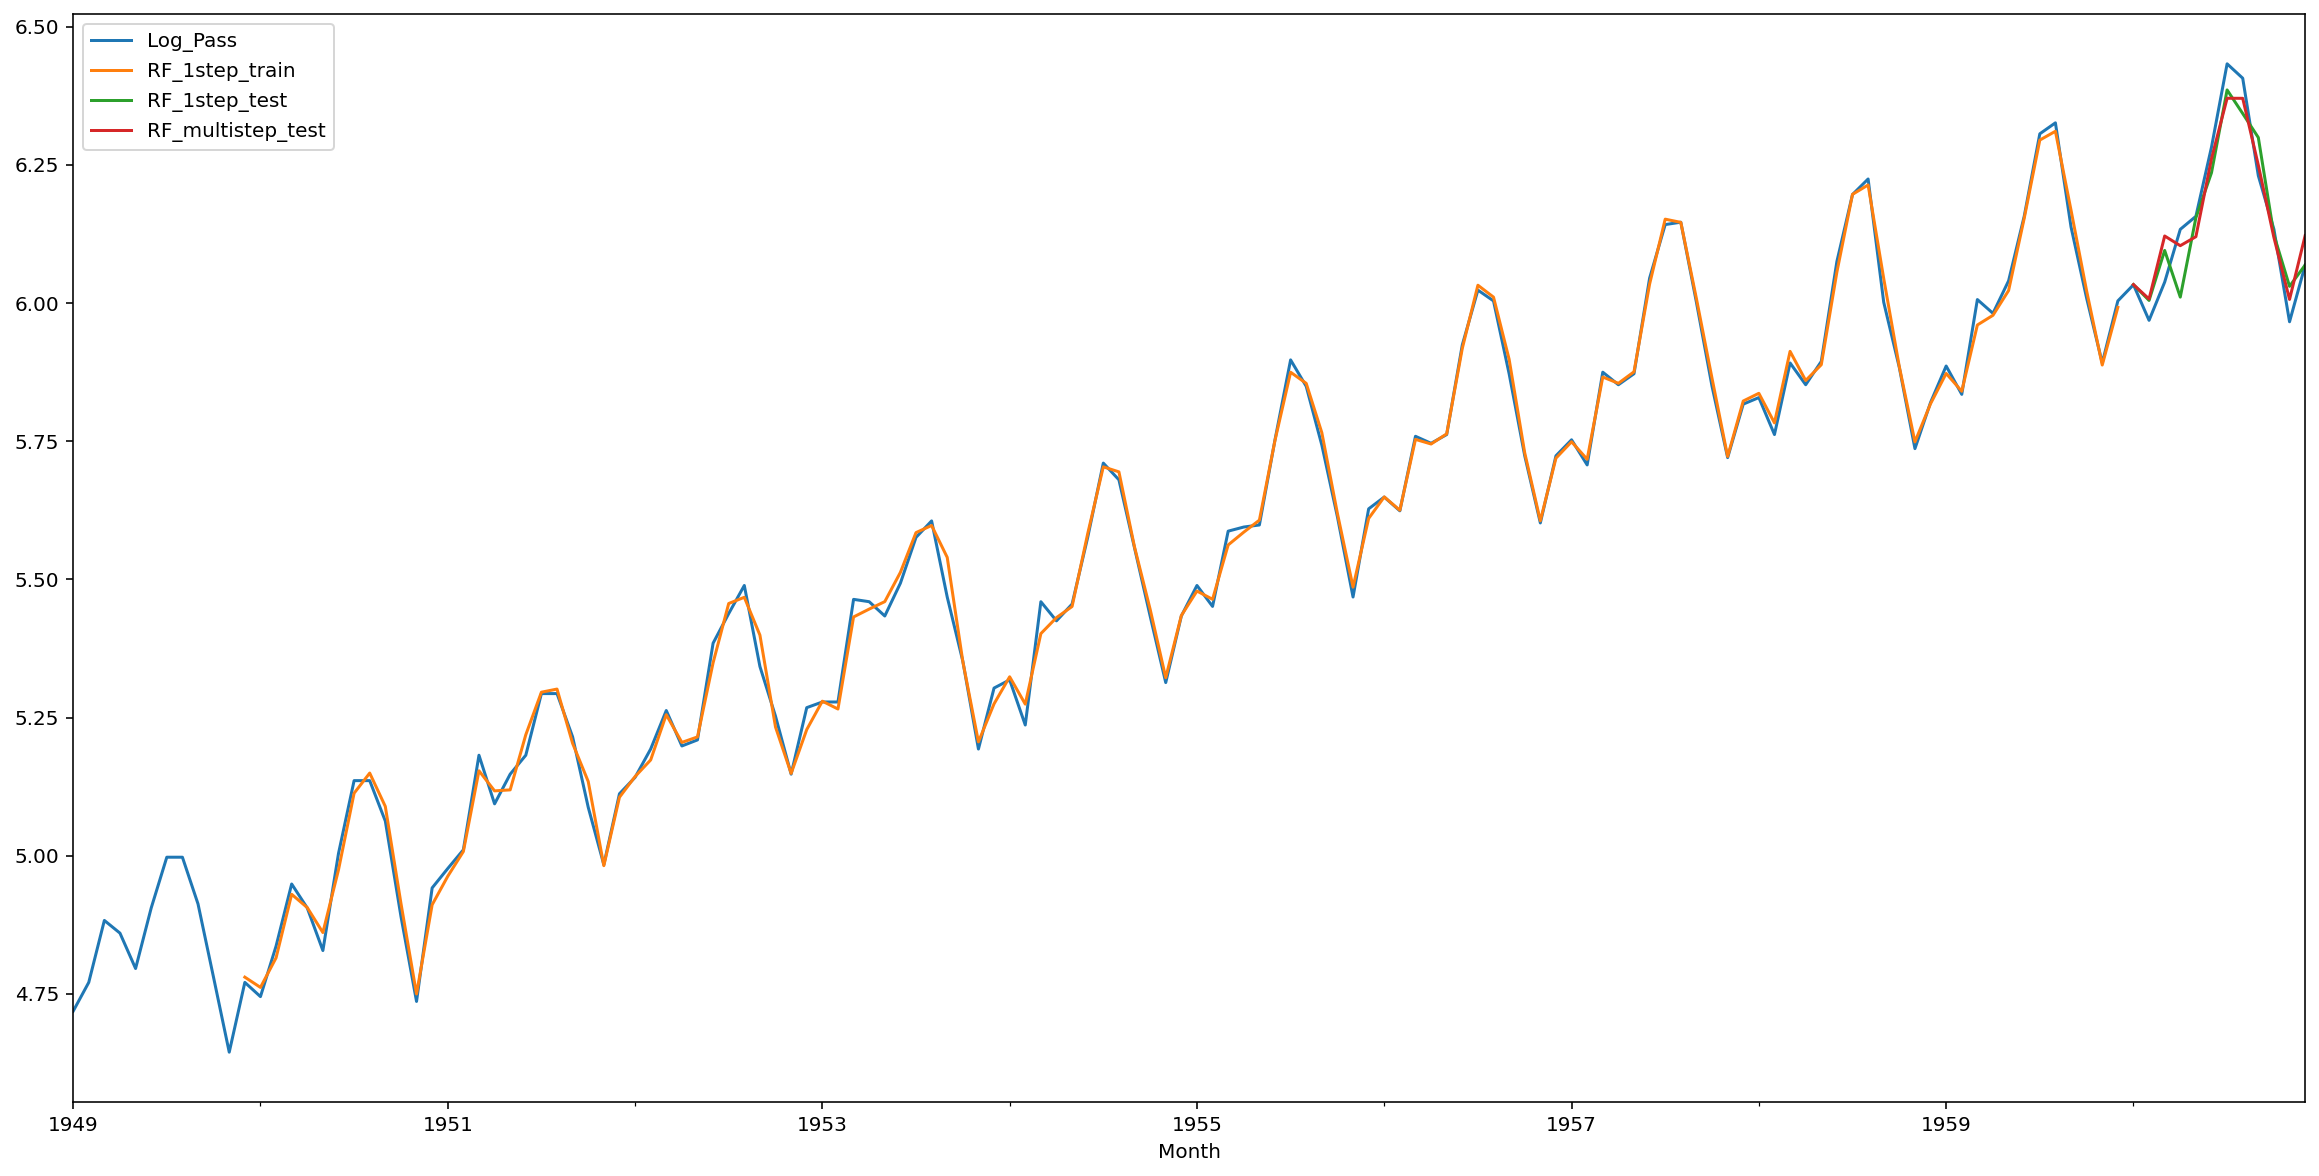

In [267]:
one_stet_and_multi_step_forecast(RandomForestRegressor(), 'RF')

In [273]:
def multi_output_forecast(model, name):
    model.fit(X_train_m, y_train_m)
    y_test_m_pred = model.predict(X_test_m).flatten()
    
    df.loc[test_idx, f'{name}_multioutput'] = last_train + np.cumsum(y_test_m_pred)
    
    mape = mean_absolute_percentage_error(test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
    print('Test MAPE (multi-output):', mape)
    
    # plot forcast
    cols = ['Log_Pass',
            f'{name}_1step_train',
            f'{name}_1step_test',
            f'{name}_multistep_test',
            f'{name}_multioutput',
            ]
    
    df[cols].plot(figsize=(20, 10));

Test MAPE (multi-output): 0.005245261617574856


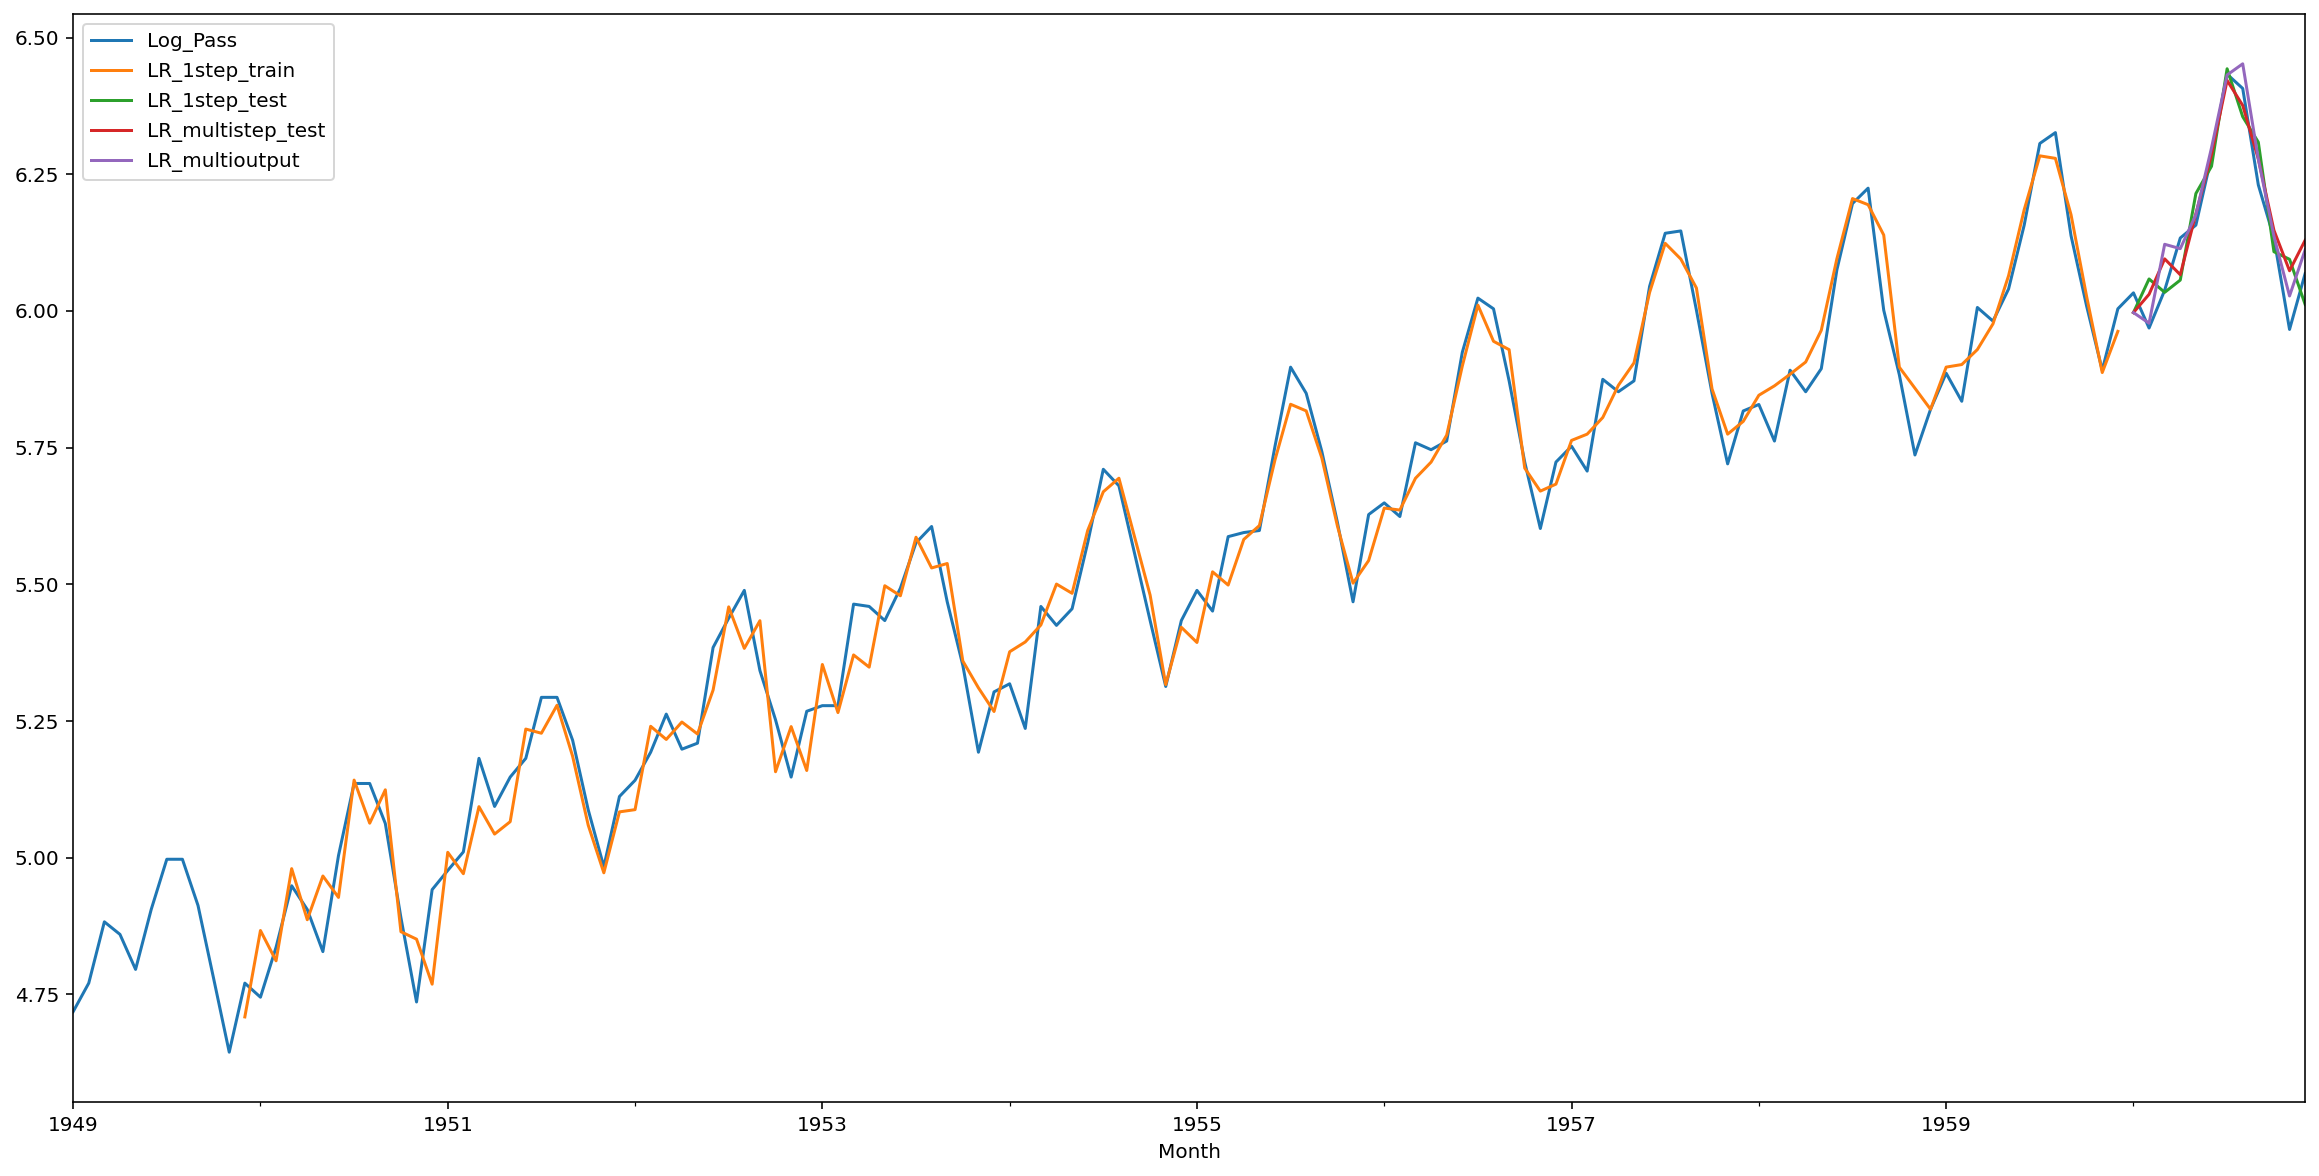

In [275]:
multi_output_forecast(LinearRegression(), 'LR')

In [270]:
# multi_output_forecast(SVR(), 'SVR')
# этот алгоритм не может выдавать несколько значений

In [279]:
# Defining the SVRWrapper class
class SVRWrapper:
    
    # Initialization method for the SVRWrapper class
    def __init__(self, h, **args):
        """
        The constructor of SVRWrapper class.

        Parameters:
        h (int): The number of steps ahead for prediction.
        **args: Variable length argument list to pass to the SVR model.
        """

        # Initialize the number of steps ahead for prediction
        self.h = h

        # Initialize a list of SVR models with 'h' models
        self.models = [SVR(**args) for _ in range(h)]
        
    # Method to fit the SVR models
    def fit(self, X, y):
        """
        Fit the models to the data.

        Parameters:
        X (np.array): The input features for training the model.
        y (np.array): The target variable for training the model.
        """
        
        # For each step ahead, fit a model to the data
        for k in range(self.h):
            # Fit the model on X and the corresponding column of Y
            self.models[k].fit(X, y[:, k])
    
    # Method to make predictions with the fitted models
    def predict(self, X):
        """
        Make predictions with the fitted models.

        Parameters:
        X (np.array): The input features for making predictions.
        """

        # Make predictions with each model
        P = [m.predict(X) for m in self.models]

        # Stack predictions from all models horizontally and return
        return np.hstack(P)

In [280]:
multi_output_forecast(SVRWrapper(N_test), 'SVR')

Test MAPE (multi-output): 0.010731361803536803


KeyError: "['SVR_1step_train', 'SVR_1step_test', 'SVR_multistep_test'] not in index"

Test MAPE (multi-output): 0.004656051013250509


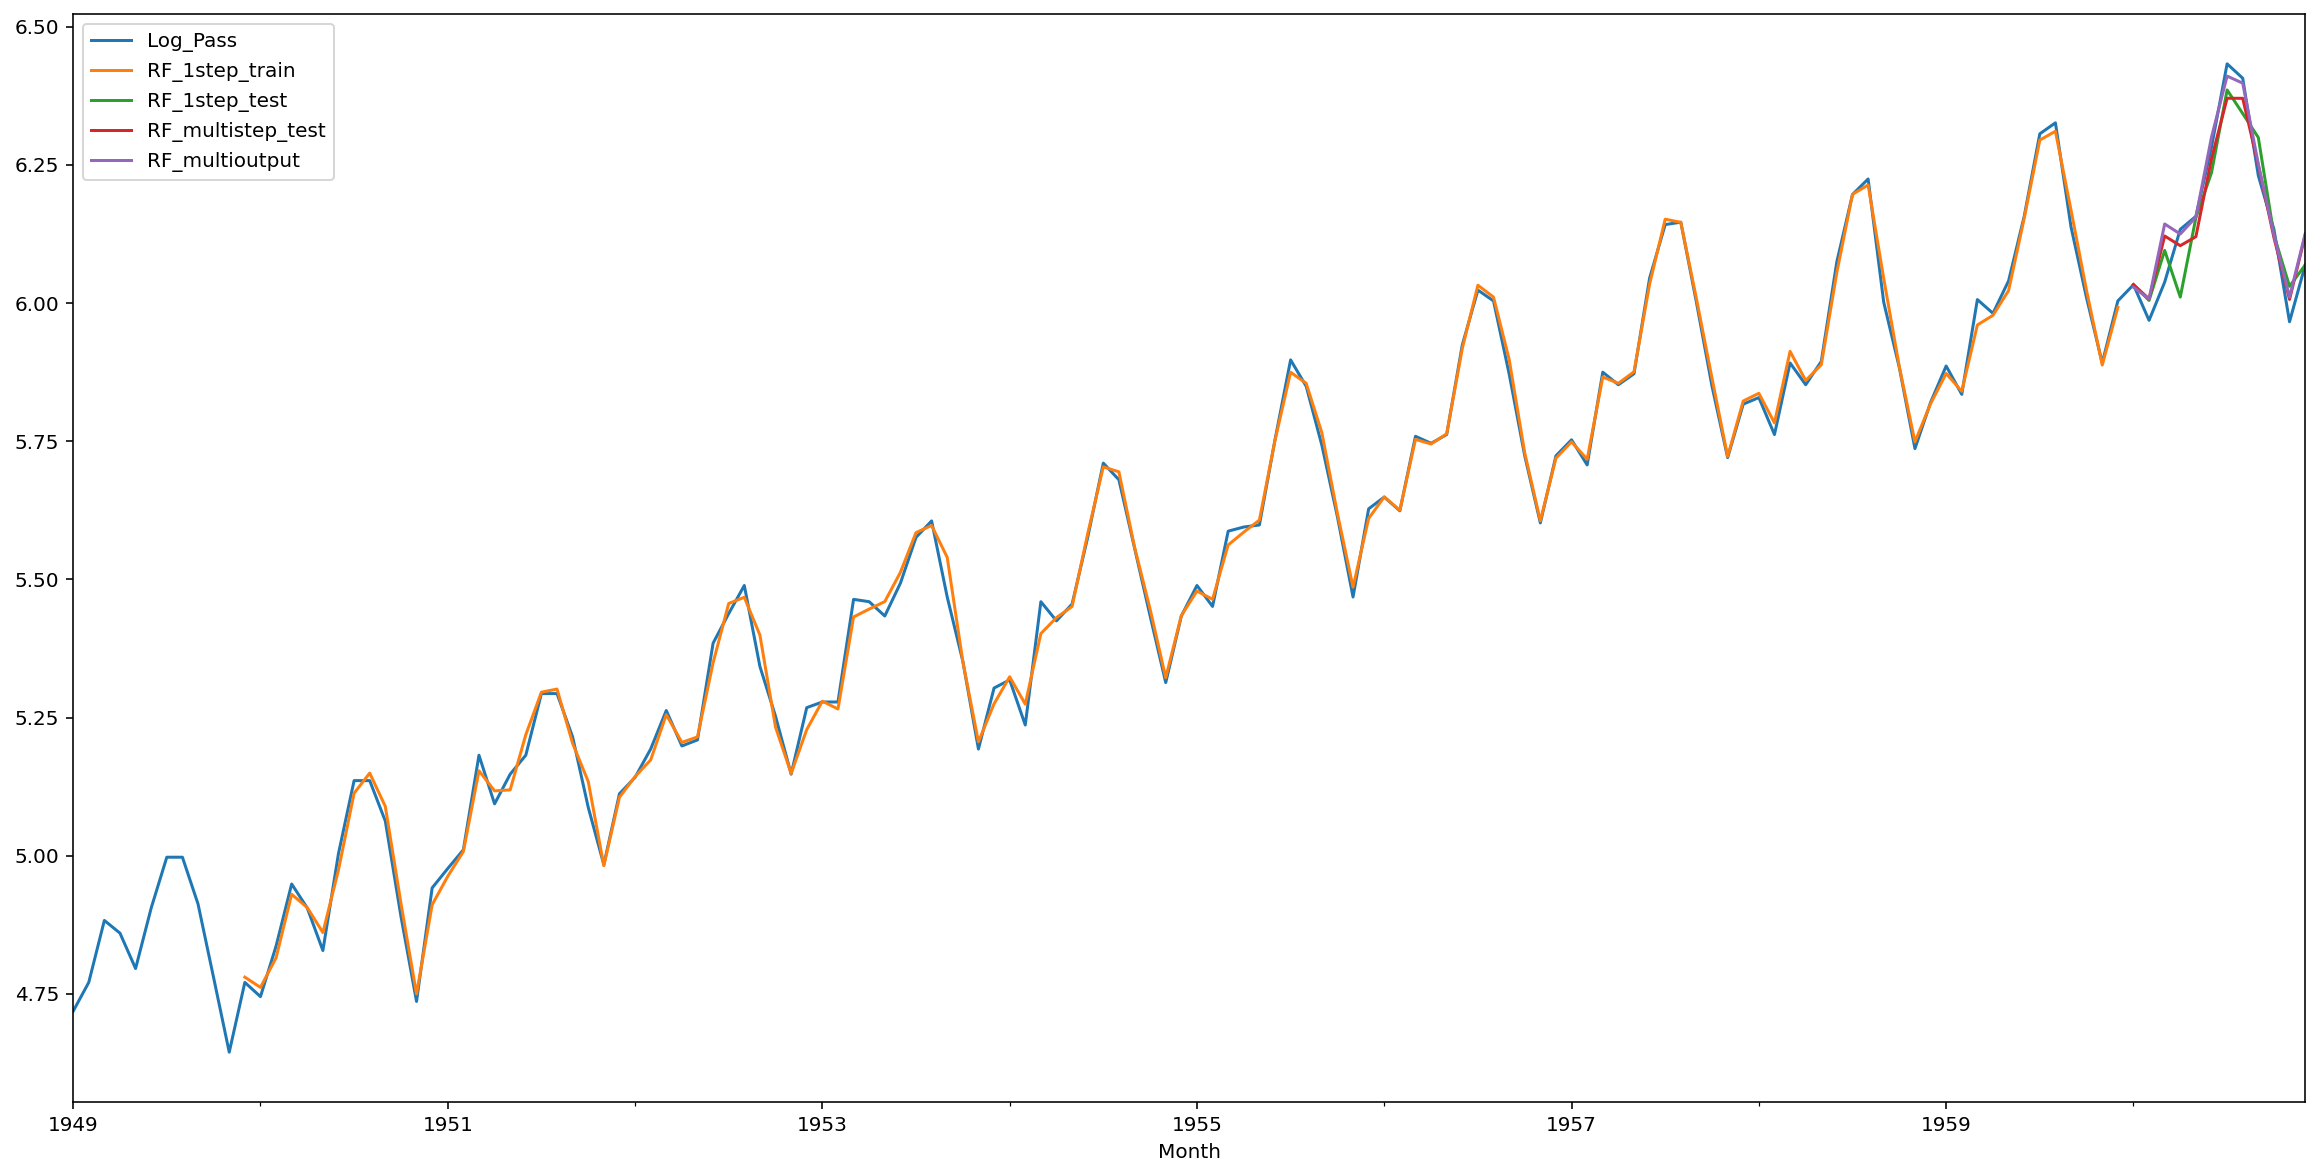

In [278]:
multi_output_forecast(RandomForestRegressor(), 'RF')